# Using document vectors to predict discourse element labels in argumentative student essays

- [x] Do word2vec first into matrix/dataframe. Check cosine similarities/semantic similarities of sentences.
- [x] Request COCA preloaded vector matrix

- [x] Get word count: 10,569,558 (raw) - 10,552,942 (elements with 2 or more tokens)
- [x] Lemmatize before creating Vocab [Maybe this helped? Hard to say.]
- [x] For diagnostic purposes: Get 10 or so discourse elements that are clearly similar and verify that the model agrees that they are similar. [Results look pretty good]

- [x] Throw it at an RF Classifier.

11/30
- [X] Combine discourse elements like rebuttal and evidence. Also remove unannotated.
        Rebuttal and counterclaim were infrequent labels, so I just removed them. Did not improve results.
    
- [X] Look for classifiers that work well with unbalanced labels. Multinomial Logistic Regression?
        Support Vector Classification is a popular choice for unbalanced classes. It does not result in much improvement.
        Additionally, LDA seems to behave well with unbalanced data: https://sci2s.ugr.es/keel/pdf/specific/articulo/xue_do_2008.pdf
    
- [ ] Think about eventually comparing results with spelling corrected and original versions. Might use neurSpell for this.
        This could be a next step, although I would expect very minor differences if any.
        
- [ ] Try removing non-argumentative classes. We will be left with claim, evidence, and position statements.
- [ ] Also try combining rebuttals and counterclaims into claims

## Langdon's thoughts

We may see better results if we include contextual information as well. 

We might try an essay-level document vector as well as a discourse-element-level vector. It should be possible to concatenate or average these vectors in a meaningful way, but I would need to look into the details.

Positional information might also be useful. Again, I'm not sure exactly how this sort of information is embedded into a vector, but I think there are methods available.

## Invocation

In [6]:
import os.path # Directories, gotta have em.
import pickle # Better than .csv + a cute name.
import pandas as pd # DataFrames. Looping is easy. Obscure functions are fast.
import numpy as np # do math on vectors with more obscure functions.
import re # one-way encryption for your codebase
import pathlib
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

# Interactive Computing
from timeit import default_timer as tm
import datetime
from tqdm import tqdm

# Spacy
import spacy
from spacy.tokens import Doc, DocBin
nlp = spacy.load('en_core_web_trf')

if not Doc.has_extension('name'):
    Doc.set_extension('name', default=None)

import gensim

## Exploration

In [2]:
persuade_corpus = pd.read_pickle('persuade_corpus_full.pkl')
display(persuade_corpus.essay_id_comp)

0         423A1CA112E2
1         423A1CA112E2
2         423A1CA112E2
3         423A1CA112E2
4         423A1CA112E2
              ...     
285378    DF920E0A7337
285379    DF920E0A7337
285380    DF920E0A7337
285381    DF920E0A7337
285382    DF920E0A7337
Name: essay_id_comp, Length: 285383, dtype: object

In [3]:
spacy_file = 'persuade.spacy'

def proc_texts(text_tuples):
    doc_bin = DocBin(attrs=["ORTH", "TAG", "HEAD", "DEP", "LEMMA", "MORPH", "POS"], store_user_data=True)
    for doc, name in nlp.pipe(text_tuples, as_tuples=True):
        doc._.trf_data = None
        doc._.name = name
#         doc.cats = {} # I can use this to store categories for spacy text categorization later on.
        doc_bin.add(doc)
    return doc_bin

if os.path.isfile(spacy_file):
    doc_bin = DocBin().from_disk(spacy_file)
else:
    doc_bin = proc_texts(text_id_tuples)
    doc_bin.to_disk(spacy_file)
docs = list(tqdm(doc_bin.get_docs(nlp.vocab), total=len(doc_bin)))

100%|██████████| 285383/285383 [01:23<00:00, 3435.15it/s]


In [79]:
discourse_types = persuade_corpus[['discourse_type']].copy()
print([type for type in discourse_types.value_counts().index.get_level_values(0)])

['Claim', 'Evidence', 'Unannotated', 'Position', 'Concluding Statement', 'Lead', 'Counterclaim', 'Rebuttal']


In [20]:
# simple_texts_file = 'simple_texts_with_stops.pkl'

simple_texts = [] # list of lists of strings
for doc in docs:
    new_doc = [t.lemma_ for t in doc if t.is_alpha]
    simple_texts.append(new_doc)

discourse_types['text'] = simple_texts

In [ ]:
# for i in range(2,10):
#     print(f'Number of discourse unit labels with {str(i)} or fewer tokens:')
#     display(discourse_types[discourse_types['text'].apply(len) <= i]['discourse_type'].value_counts())
#     print(f'Examples of discourse elements with exactly {str(i)} tokens:')
#     display(discourse_types[(discourse_types['text'].apply(len) == i)]) #& (discourse_types['discourse_type'].str.match('Claim'))][:5])

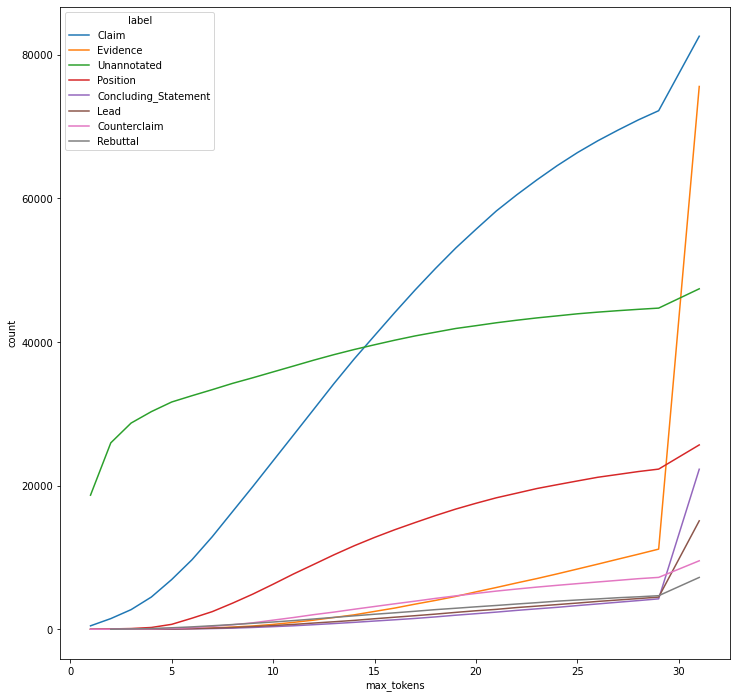

In [48]:
tuples = []
total = discourse_types['discourse_type'].value_counts()
for label, count in total.items():
    tuples.append((label.replace(" ", "_"), 31, count))
    
for i in range(1,30):
    s = discourse_types[discourse_types['text'].apply(len) <= i]['discourse_type'].value_counts()
    for label, count in s.items():
        tuples.append((label.replace(" ", "_"), i, count))

data_loss = pd.DataFrame(tuples, columns=['label', 'max_tokens', 'count'])

plt.rcParams["figure.figsize"] = (12,12)
ax = sns.lineplot(data=data_loss,x='max_tokens',y='count',hue='label')
# sns.lineplot(data_loss)

## Cleaning
Tried removing 2 and 10. 2 made little difference; 10 seemed overly aggressive.
Now removing anything with fewer than 5 words. This costs about 100,000 words and gives us more meaningful document vectors.

In [62]:
elements = discourse_types[discourse_types['text'].apply(len) >= 5]
display(sum(discourse_types['text'].apply(len)))
display(sum(elements['text'].apply(len)))
display(elements)

10569558

10509421

,discourse_type,text
1,Lead,"[modern, human, today, be, always, on, their, ..."
2,Position,"[they, be, some, really, bad, consequence, whe..."
3,Evidence,"[some, certain, area, in, the, United, States,..."
4,Evidence,"[when, people, have, phone, they, know, about,..."
5,Claim,"[driving, be, one, of, the, way, how, to, get,..."
...,...,...
285377,Unannotated,"[next, it, can, change, your, perspective, on,..."
285378,Evidence,"[one, person, can, change, your, option, but, ..."
285379,Unannotated,"[finally, it, inform, you, about, what, other,..."
285380,Evidence,"[have, more, than, one, person, opinion, might..."


In [ ]:
matcher = DependencyMatcher(nlp.vocab)
matches_returned = 0

if not word1dict:
    word1dict = {'LEMMA': word1} 
if not word2dict:
    word2dict = {'LEMMA': word2}
pattern = [
    {
        "RIGHT_ID": ('word1'),
        "RIGHT_ATTRS": word1dict
    },
    {
        "LEFT_ID": ('word1'),
        "REL_OP": ">",
        "RIGHT_ID": ('word2'),
        "RIGHT_ATTRS": word2dict
    }
]
matcher.add(matchname, [pattern])

[(0, [0]), (1, [3, 18, 2]), (2, [1]), (3, [7]), (4, [6, 17, 2, 2])]


In [63]:
# Looking at the counts, I want to try a simple paring procedure first
# Nervous to combine counterclaim with claim and rebuttal with evidence
# Polarity likely to be different -- could incur strange results
# For now, just remove unannotated, counterclaim, rebuttal.

excluded_labels = '|'.join(['Unannotated',
                           'Counterclaim',
                           'Rebuttal'])
print('\nPared dataset:')
test = (elements[~elements['discourse_type'].str.match(excluded_labels)])
print(test['discourse_type'].value_counts())
elements = test
display(elements)


Pared dataset:
Claim                   78094
Evidence                75574
Position                25421
Concluding Statement    22276
Lead                    15074
Name: discourse_type, dtype: int64


,discourse_type,text
1,Lead,"[modern, human, today, be, always, on, their, ..."
2,Position,"[they, be, some, really, bad, consequence, whe..."
3,Evidence,"[some, certain, area, in, the, United, States,..."
4,Evidence,"[when, people, have, phone, they, know, about,..."
5,Claim,"[driving, be, one, of, the, way, how, to, get,..."
...,...,...
285374,Claim,"[it, inform, you, about, what, other, people, ..."
285376,Evidence,"[one, opinion, of, a, person, might, destroy, ..."
285378,Evidence,"[one, person, can, change, your, option, but, ..."
285380,Evidence,"[have, more, than, one, person, opinion, might..."


## Training Document Vectors

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(elements['text'], elements['discourse_type'], test_size=0.33, random_state=42)
# display(X_train.iloc[[99]])
# display(y_train.iloc[[99]])

# for ind, item in enumerate(X_train[:5].iteritems()):
#     print(item[0])
#     print(item[1])
#     print(y_train.iloc[ind])

In [65]:
def toks_to_tags(texts, labels):
    '''
    texts and labels must have matched indices
    '''
    for ind, text in enumerate(texts.iteritems()):
        yield(gensim.models.doc2vec.TaggedDocument(text[1], [str(text[0])]))
        # yield(gensim.models.doc2vec.TaggedDocument(text[1], [str(text[0]), labels.iloc[ind]]))

train_corpus = list(toks_to_tags(X_train, y_train))
test_corpus = list(toks_to_tags(X_test, y_test))

In [66]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=75, workers=4)
model.build_vocab(train_corpus)
print(f"The size of the model's vocabulary is {len(model.wv):,}.")
print(f"Word 'phone' appeared {model.wv.get_vecattr('phone', 'count')} times in the training corpus.")

The size of the model's vocabulary is 20,498.
Word 'phone' appeared 17687 times in the training corpus.


In [67]:
st = tm()
model.train(train_corpus,
            total_examples=model.corpus_count,
            epochs=model.epochs)
print(datetime.timedelta(seconds=round(tm()-st)))

0:12:34


## Sanity checks

In [68]:
print('The number of computed word vectors is...', len(model.wv))
word_vectors = model.wv
print('The word vector for phone is...')
print(word_vectors['phone'])

diag_words = ['phone', 'election', 'help', 'believe', 'argue', 'car', 'drive']

def simmer(diag_words, num_results):
    print()
    for word in diag_words:
        print(f'Most similar words to {word}:')
        for sim_word, score in word_vectors.most_similar(positive=[word])[:num_results]:
            print(sim_word, round(score, 2), end=' -- ')
        print('\n')
        
simmer(diag_words, 4)

print('We also have paragraph or document vectors')
print('The word vector for discourse element 1 is..')
[print(word, end=' ') for word in X_train.iat[1]]
print()
print(model.dv[1])
print()

# print('We also have keyed vectors that are similar to document vectors but represent a label')
# print('The keyed vector for Claim is...')
# print(model.dv['Claim'])

The number of computed word vectors is... 20498
The word vector for phone is...
[ 1.7124335  -1.1361262  -1.2616229   1.2342081  -1.5391499   0.05046156
  0.85787684 -1.442456   -0.98775357  0.16887935  1.8886021   1.1511071
  0.68304205 -0.5450018  -0.297827   -0.9179942   0.12076015  0.6800315
 -0.7491615   0.03277365  0.26218262 -0.29879156  0.37283972  0.5867966
 -1.128925   -1.9353575   3.0641873   1.1637187   1.2719564   0.22442006
  1.9964712  -1.6253396  -0.7347243   1.3173035   0.18670371 -0.03096761
 -0.63291526  1.342151    1.3295039   2.2882786   1.0582062  -1.1030662
  0.95357096 -0.43697706 -1.5980642  -0.30063522 -0.06184153  0.7889357
 -0.6547678  -0.4907204   1.7826185   1.0628926  -1.0260106  -0.57753134
 -0.8089612   1.4385499   1.2607048  -0.9000962  -1.176277   -0.45551875
 -0.7914624  -0.6916918   1.3590461   0.7316486   1.9795136   2.0077355
 -0.78332096  1.332319   -1.3428117   0.298658    1.4110324   0.38307032
  1.1986482  -0.15478772 -0.7562401  -0.37603143  

## Evaluating Vectors

In [69]:
def diagnosticator(X_test, y_test, X_train, y_train, debug=False):
    y_pred = []
    y_true = []
    for ind, doc in tqdm(X_test.iteritems(), total=len(X_test)):
        inferred_vector = model.infer_vector(doc)
        pred = int(model.dv.similar_by_vector(inferred_vector, topn=1)[0][0])
        if debug:
            print(f'True: {y_test.at[ind]}')
            print('Unseen text:', end='  ')
            [print(word, end=' ') for word in doc]
            print()
        if type(pred) == int:
            pred_label = y_train.at[pred]
            if debug:
                print('Most similar text:', end='  ')
                [print(word, end=' ') for word in X_train[pred]]
                print()
                print(f'Predicted: {pred_label}')
                print('---')
        elif type(pred) == str:
            pred_label = pred
            if debug:
                print(f'Most similar to keyed vector: {pred}')
                print('---')

        y_true.append(y_test.at[ind])
        y_pred.append(pred_label)
    return y_true, y_pred

In [70]:
x, y = diagnosticator(X_test=X_test[:5],
                      y_test=y_test,
                      X_train=X_train,
                      y_train=y_train,
                      debug=True)

100%|██████████| 5/5 [00:00<00:00, 52.67it/s]

True: Claim
Unseen text:  one advantage of limit car usage be you do nt have to pay gasoline anymore 
Most similar text:  one advantage of limit car usage be that there would be less pollution 
Predicted: Claim
---
True: Evidence
Unseen text:  homework be almost always give to student to test their knowledge and what they learn this be a lead factor in be busy and unable to be part of a after school activity church or non school relate event also make extracurricular activity more difficult to be a part of family time and curfew also relate to unavailability for after school event 
Most similar text:  student usually have to bring their phone to school mainly for after school activity 
Predicted: Claim
---
True: Claim
Unseen text:  the author support the idea with fact and more idea that would make it safe and beneficial to we if we travel to Venus for further examination 
Most similar text:  it would be safe and beneficial 
Predicted: Claim
---
True: Claim
Unseen text:  some people ma

In [71]:
y_true, y_pred = diagnosticator(X_test=X_test[:1000],
                                y_test=y_test,
                                X_train=X_train,
                                y_train=y_train)

100%|██████████| 1000/1000 [00:06<00:00, 148.87it/s]


                      precision    recall  f1-score   support

               Claim       0.51      0.64      0.57       362
Concluding Statement       0.32      0.16      0.21       114
            Evidence       0.64      0.47      0.54       331
                Lead       0.36      0.32      0.34        73
            Position       0.36      0.54      0.43       120

            accuracy                           0.49      1000
           macro avg       0.44      0.43      0.42      1000
        weighted avg       0.50      0.49      0.49      1000



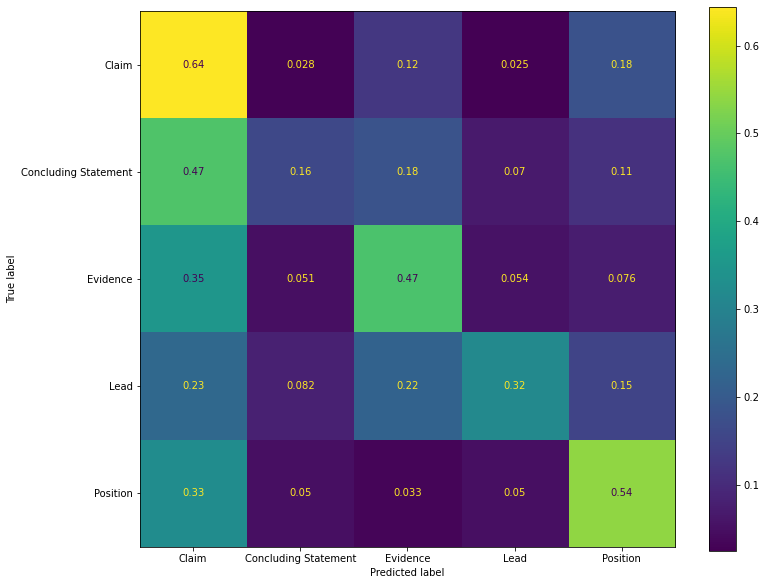

In [128]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, NuSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

print(classification_report(y_true, y_pred))
plt.rcParams["figure.figsize"] = (12,10)
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize='true')
plt.show()

## Modelling

In [75]:
# X_train_log = np.array([model.dv[i] for i in range(len(model.dv))])
def vector_retrieval(model, labels, input_docs):
    targets, feature_vectors = zip(*[(labels.at[int(doc.tags[0])], model[doc.tags[0]]) for doc in input_docs])
    return targets, feature_vectors
def vector_inference(model, labels, input_docs):
    targets, feature_vectors = zip(*[(labels.at[int(doc.tags[0])], model.infer_vector(doc.words, steps=20)) for doc in input_docs])
    return targets, feature_vectors

y_cls_train, X_cls_train = vector_retrieval(model, y_train, tqdm(train_corpus))
y_cls_test, X_cls_test = vector_inference(model, y_test, tqdm(test_corpus))

100%|██████████| 71425/71425 [04:09<00:00, 286.09it/s]


In [129]:
def test_classifier(name, classifier):
    print(name)
    st = tm()
    classifier.fit(X_cls_train, y_cls_train)
    y_cls_pred = classifier.predict(X_cls_test)
    print(classification_report(y_cls_test, y_cls_pred))
    print(datetime.timedelta(seconds=round(tm()-st)))
    ConfusionMatrixDisplay.from_predictions(y_cls_test, y_cls_pred, normalize='true')
    plt.show()

3-Neighbors Classifier
                      precision    recall  f1-score   support

               Claim       0.41      0.86      0.55     25897
Concluding Statement       0.27      0.04      0.06      7200
            Evidence       0.78      0.13      0.22     24867
                Lead       0.54      0.10      0.16      4986
            Position       0.42      0.56      0.48      8475

            accuracy                           0.43     71425
           macro avg       0.48      0.33      0.29     71425
        weighted avg       0.53      0.43      0.35     71425

0:01:41


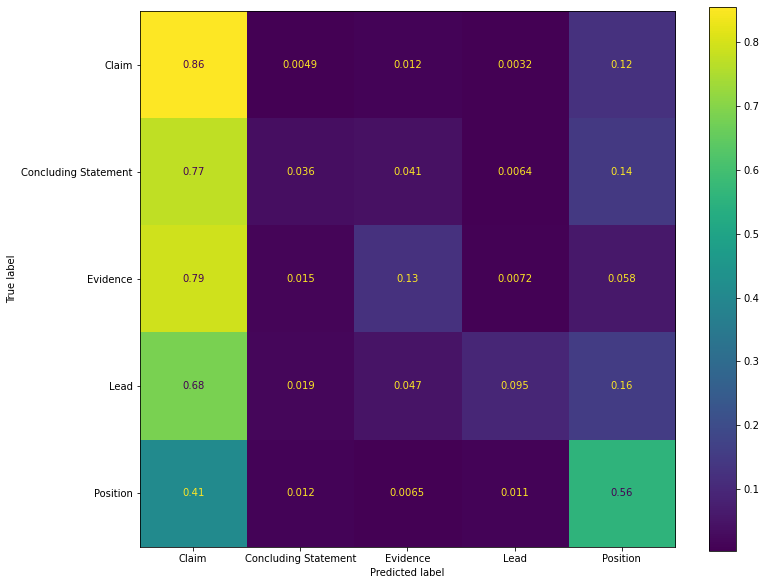

Random Forest Classifier
                      precision    recall  f1-score   support

               Claim       0.62      0.65      0.64     25897
Concluding Statement       0.50      0.01      0.02      7200
            Evidence       0.52      0.91      0.66     24867
                Lead       0.86      0.00      0.00      4986
            Position       0.90      0.07      0.14      8475

            accuracy                           0.56     71425
           macro avg       0.68      0.33      0.29     71425
        weighted avg       0.62      0.56      0.48     71425

0:03:05


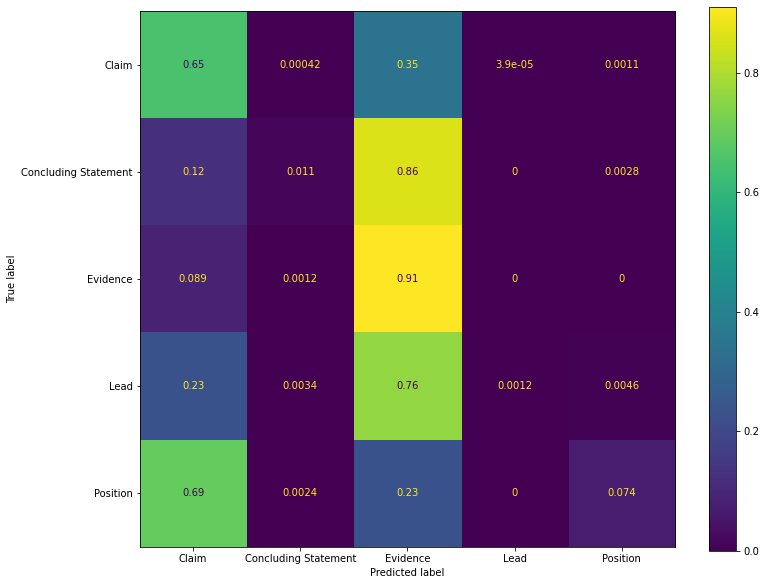

Linear Discriminant Analysis
                      precision    recall  f1-score   support

               Claim       0.62      0.56      0.59     25897
Concluding Statement       0.30      0.60      0.40      7200
            Evidence       0.56      0.67      0.61     24867
                Lead       0.38      0.25      0.30      4986
            Position       0.46      0.04      0.07      8475

            accuracy                           0.52     71425
           macro avg       0.46      0.42      0.39     71425
        weighted avg       0.53      0.52      0.50     71425

0:00:03


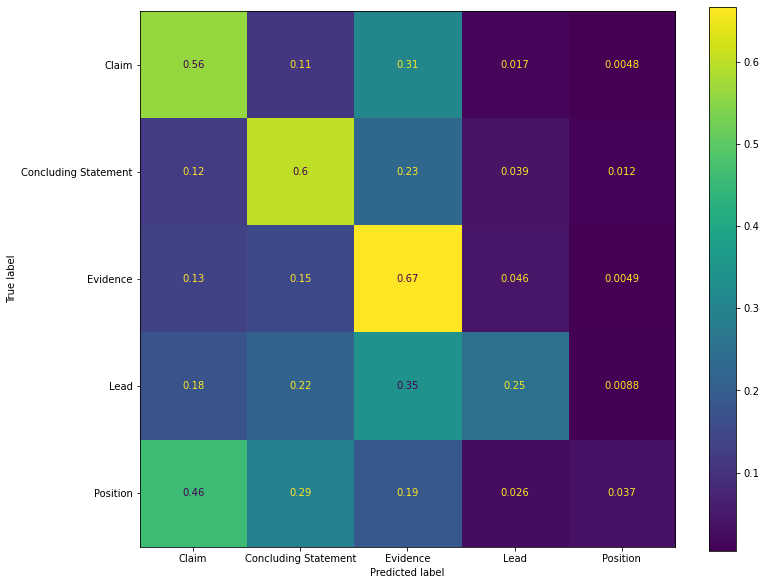

LinearSVC


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


                      precision    recall  f1-score   support

               Claim       0.67      0.48      0.56     25897
Concluding Statement       0.24      0.68      0.35      7200
            Evidence       0.61      0.61      0.61     24867
                Lead       0.28      0.34      0.31      4986
            Position       0.43      0.09      0.14      8475

            accuracy                           0.49     71425
           macro avg       0.45      0.44      0.39     71425
        weighted avg       0.55      0.49      0.49     71425

0:05:21


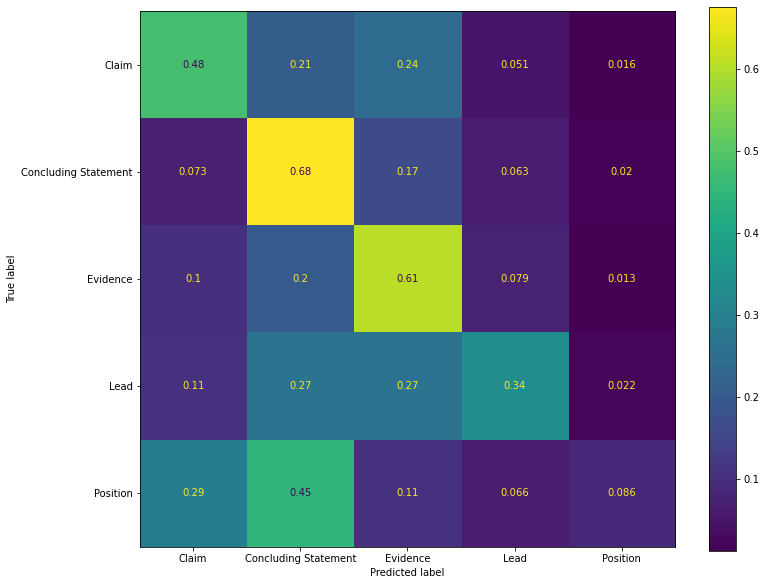

AdaBoost Classifier
                      precision    recall  f1-score   support

               Claim       0.56      0.74      0.64     25897
Concluding Statement       0.39      0.14      0.20      7200
            Evidence       0.56      0.77      0.65     24867
                Lead       0.33      0.02      0.03      4986
            Position       0.44      0.02      0.05      8475

            accuracy                           0.56     71425
           macro avg       0.46      0.34      0.31     71425
        weighted avg       0.52      0.56      0.49     71425

0:01:27


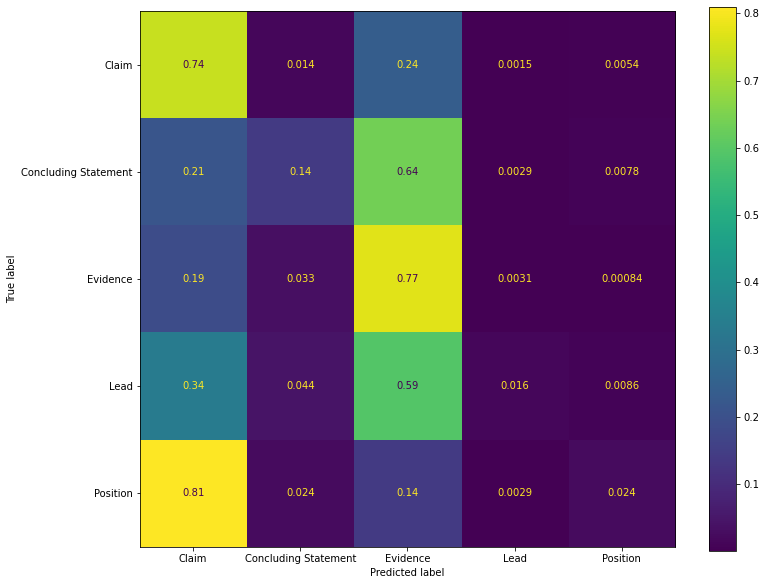

In [127]:
dict_of_classifiers = {"3-Neighbors Classifier":KNeighborsClassifier(n_neighbors=3),
                       "Random Forest Classifier": RandomForestClassifier(),
                       "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
                       "LinearSVC": LinearSVC(class_weight='balanced'),
                       "AdaBoost Classifier": AdaBoostClassifier(),
                        }

for name, classifier in dict_of_classifiers.items():
    print(name)
    st = tm()
    classifier.fit(X_cls_train, y_cls_train)
    y_cls_pred = classifier.predict(X_cls_test)
    print(classification_report(y_cls_test, y_cls_pred))
    print(datetime.timedelta(seconds=round(tm()-st)))
    ConfusionMatrixDisplay.from_predictions(y_cls_test, y_cls_pred, normalize='true')
    plt.show()

quadratic
                      precision    recall  f1-score   support

               Claim       0.74      0.35      0.48     25897
Concluding Statement       0.24      0.22      0.23      7200
            Evidence       0.57      0.87      0.69     24867
                Lead       0.13      0.17      0.14      4986
            Position       0.46      0.43      0.44      8475

            accuracy                           0.52     71425
           macro avg       0.43      0.41      0.40     71425
        weighted avg       0.56      0.52      0.50     71425

0:00:02


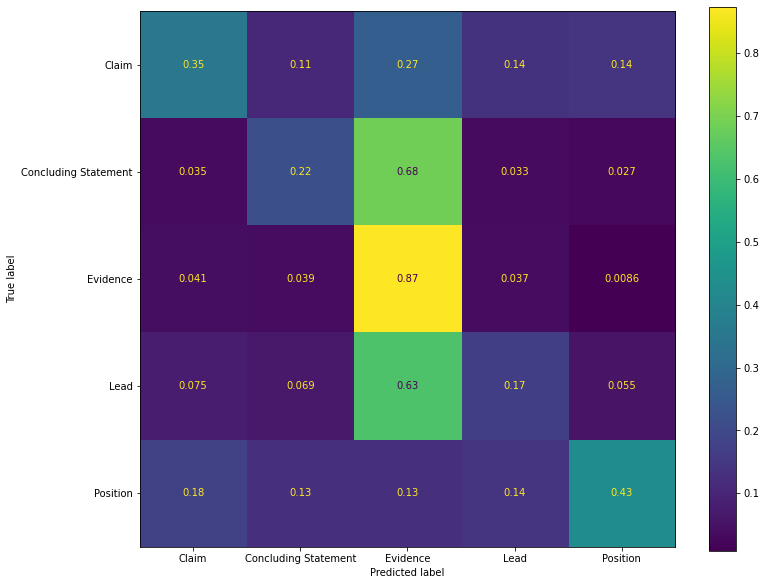

In [130]:
test_classifier('quadratic', QuadraticDiscriminantAnalysis())